# Deep Convolutional Methods for Population Estimation
<hr>

<p align="center">
    <img src="Sample1.jpg" align="left" style="height: 200px;"/>
    <img src="Sample2.jpg" align="left" style="height: 200px;"/>
    <img src="Sample3.jpg" align="left" style="height: 200px;"/>
    <img src="Sample4.jpg" align="left" style="height: 200px;"/>
    <img src="Sample5.jpg" align="left" style="height: 200px;"/>
</p>


### Objective
This model estimates population statistics from satellite imagery of a region.

Population estimation based on aerial or satellite photography is a highly practical and well-studied computational task. According to Robinson et. al. [<a href=#1>1</a>], "knowing where people live is a fundamental component of many decision making processes such as urban development, infectious disease containment, evacuation planning, risk management, conservation planning, and more." However, the recent advances of deep neural networks have received limited use in population estimation, with only a handful of relevant papers [<a href=#1>1</a>,<a href=#2>2</a>,<a href=#3>3</a>]. This project expands on that work through two distinct contributions. First, it creates a novel dataset of 37,000 U.S. Census tracts. Second, it develops a deep convolutional model for population estimation trained on that dataset. The resulting model predicts the total population of a tract given its satellite image. Model quality is evaluated quantitatively through performance on an unseen test set of census tract images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

## Data

This project introduces a novel dataset of geographic information for population estimation by using U.S. Census Tracts. These ~70,000 tracts divide the land area of the United States into administrative regions for census record-keeping. Census tracts are subdivisions of counties and completely segement the U.S. landmass. They are the smallest geography for which American Community Survey data are tabulated for all types subject matter tables. 

There are two components to this data: <b>images</b> and <b>census records</b>.

#### Images

<img src="Sample2.jpg">
<p style="text-align: center;"><i>Census Tract 7807, Kandiyohi County, Minnesota</i></p>

Naively acquiring satellite imagery for every census tract would be a time-consuming task. Fortunately, a simple work-around exists. Images are scraped from the media feed of a Twitter bot (<a href="https://twitter.com/everytract">@everytract</a>) run by Neil Freeman. The bot tweets an image of a census tract every thirty minutes. It has currently (as of November 2020) posted ~36,000 of the ~70,000 total census tracts for the United States, providing a large and robust data set. Images are large and precisely delineated. A representative sample is shown above. Images were scraped using this <a href="https://github.com/furyutei/twMediaDownloader">application</a> to access the Twitter API. There are ~36,200 images in total used in this project.

#### Census Records

The census records used for this project where manually collected from the U.S. Census Bureau's online data portal (https://www.census.gov/data.html). The latest estimates from the 2018 American Community Survey were used for all (~37,000) census tracts corresponding to the available image data set. Estimates of total population and total housing units were collected for each census tract.

### Preprocessing

Census data for all tracts is aggregated into a single .csv file, ```Census_Combined.csv```. 

In [3]:
# Last Tract: Census Tract 5603, Meeker County, Minnesota -> Row 36285

DATA_PATH = "drive/My Drive/population-estimation/"

# Read Census data from Census_Combined.csv
census = pd.read_csv(DATA_PATH+"Census_Combined.csv", nrows=36285)
census

,Unnamed: 0,GEO_ID,NAME,TOTAL POPULATION,TOTAL HOUSING UNITS,STANDARDIZED POPULATION
0,0,1400000US01001020100,"Census Tract 201, Autauga County, Alabama",1923,779,NaN
1,1,1400000US01001020200,"Census Tract 202, Autauga County, Alabama",2028,852,NaN
2,2,1400000US01001020300,"Census Tract 203, Autauga County, Alabama",3476,1397,NaN
3,3,1400000US01001020400,"Census Tract 204, Autauga County, Alabama",3831,1867,NaN
4,4,1400000US01001020500,"Census Tract 205, Autauga County, Alabama",9883,4488,NaN
...,...,...,...,...,...,...
36280,36280,1400000US27091790500,"Census Tract 7905, Martin County, Minnesota",5837,3043,NaN
36281,36281,1400000US27091790600,"Census Tract 7906, Martin County, Minnesota",4505,2279,NaN
36282,36282,1400000US27093560100,"Census Tract 5601, Meeker County, Minnesota",5083,2232,NaN
36283,36283,1400000US27093560200,"Census Tract 5602, Meeker County, Minnesota",4917,2484,NaN


### Exploratory Data Analysis:

The accumulated census tracts showed a range of population values from 0 to ~40,000, with a mean population around 4,400. Manually inspecting imagery for very low population tracts confirmed that these population values were accurate and not in error. Because the entire land mass of the United States is divided into census tracts, this results in tracts for regions like airports, national parks, and remote islands with very low populations.

In [4]:
import statistics
print("Population Range: ",min(census["TOTAL POPULATION"])," - ",max(census["TOTAL POPULATION"]))
print("Mean Population: ", int(statistics.mean(census["TOTAL POPULATION"])))

Population Range:  0  -  39919
Mean Population:  4446


In [5]:
from PIL import Image

# Reshape all images to square dimensions
'''
for img_name in os.listdir("./Images"):
    try:
        img = Image.open("./Images/"+img_name)
        square_img = makeSquare(img,(255,255,255))
        square_img.save("./Images/"+img_name)
    except:
        print(img_name+" is not an image.")
'''        
def makeSquare(img, background_color):
    width, height = img.size
    if img.mode != 'RGB':
        img = img.convert('RGB')
    if width == height:
        return img
    elif width > height:
        result = Image.new(img.mode, (width, width), background_color)
        result.paste(img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(img.mode, (height, height), background_color)
        result.paste(img, ((height - width) // 2, 0))
        return result

### Create Train / Val / Test Split
70 % Train | 10% Validation | 20% Test


In [6]:
from sklearn.model_selection import train_test_split

train_census, test_census = train_test_split(census, test_size = 0.2, random_state = 12)

In [7]:
### Standardize Population Data:

from sklearn.preprocessing import StandardScaler

train_pops = np.array(train_census["TOTAL POPULATION"])
train_pops = train_pops.reshape(-1,1)
scaler = StandardScaler()

scaler.fit(train_pops)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
train_census["STANDARDIZED POPULATION"] = scaler.transform(np.array(train_census["TOTAL POPULATION"]).reshape(-1,1))
test_census["STANDARDIZED POPULATION"] = scaler.transform(np.array(test_census["TOTAL POPULATION"]).reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Create tf Data Sets

Images are divided using a 70 % Train | 10% Validation | 20% Test split, grouped into batches of 64, and processed in Tensorflow datasets for quick use by the model.

In [10]:
BATCH_SIZE = 32

In [11]:
# Directories of train and test sets -> update these based on your local configuration
TRAIN_DIR = 'drive/My Drive/population-estimation/Images/train'
TEST_DIR = 'drive/My Drive/population-estimation/Images/test'

In [12]:
pop_lookup = {}

for idx,row in train_census.iterrows():
    pop_lookup[row["NAME"]] = row["STANDARDIZED POPULATION"]

for idx,row in test_census.iterrows():
    pop_lookup[row["NAME"]] = row["STANDARDIZED POPULATION"]

The cell below can time out on hosted systems like Google Colab, and needs to be run repeatedly until all filenames in the directories have been cached.

In [13]:
cached = False

while(not cached):
  try:
    train_names = sorted([img_name for img_name in os.listdir(TRAIN_DIR+"/train")])
    test_names = sorted([img_name for img_name in os.listdir(TEST_DIR+"/test")])
    cached = True
  except:
    print("Google Drive Timeout")

In [14]:
train_labels = [pop_lookup[img_name[:-4]] for img_name in train_names]
test_labels = [pop_lookup[img_name[:-4]] for img_name in test_names]

In [15]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR, labels=train_labels, label_mode='int', class_names=None,
    color_mode='rgb', batch_size=BATCH_SIZE, image_size=(500, 500), shuffle=True, seed=12,
    validation_split=0.125, subset="training", interpolation='bilinear', follow_links=True
)

Found 28947 files belonging to 1 classes.
Using 25329 files for training.


In [16]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR, labels=train_labels, label_mode='int', class_names=None,
    color_mode='rgb', batch_size=BATCH_SIZE, image_size=(500, 500), shuffle=True, seed=12,
    validation_split=0.125, subset="validation", interpolation='bilinear', follow_links=True
)

Found 28947 files belonging to 1 classes.
Using 3618 files for validation.


In [17]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR, labels=test_labels, label_mode='int', class_names=None,
    color_mode='rgb', batch_size=BATCH_SIZE, image_size=(500, 500), shuffle=True, seed=None,
    validation_split=None, subset=None, interpolation='bilinear', follow_links=True
)

Found 7231 files belonging to 1 classes.


### Visualize Tensorflow Datasets

Visualizations for test and training sets below display a sample of 32 images and their corresponding stardarized population counts.

Image Batch Shape:  (32, 500, 500, 3)
Labels:  [ 0.04721438 -0.5404139  -0.6712888  -1.2087485  -0.5905826  -1.026396
  0.17329054 -0.21104543 -0.4296065   0.5715865   1.4467033  -0.29567787
  0.74390507  0.87696123  0.8996462  -0.33799407  0.6256814  -0.46843272
  0.31899792 -0.7772975   1.2320684  -0.6992088   1.6342907  -0.5517564
 -0.40386778 -1.3300258  -0.99105984 -0.08802301  0.09956434 -0.51511145
 -0.1818167  -0.08540552]


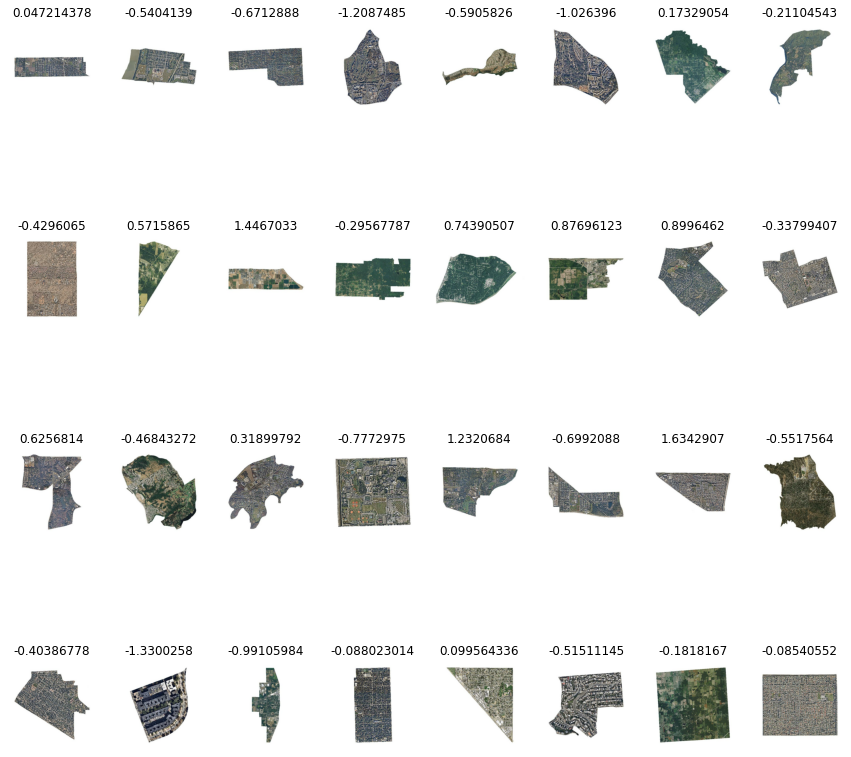

In [18]:
from matplotlib import pyplot as plt

# Test data set visualization

for image, label in test_data.take(1):
    print("Image Batch Shape: ", image.numpy().shape)
    print("Labels: ", label.numpy())
    plt.figure(figsize=(15, 15))
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image[i].numpy().astype(np.uint8))
        plt.title(label[i].numpy())
        plt.axis("off")

Image Batch Shape:  (32, 500, 500, 3)
Labels:  [-1.3108308  -0.8039087  -0.91035366 -0.19359544 -0.22064291 -0.34192032
 -0.55742764  0.22520424 -0.5648439  -0.18050794 -0.41608277 -0.03131056
  0.44332907 -0.52907145 -0.5460852   1.5326445   0.23218423 -0.12510423
  1.9959416  -1.2868371  -1.0569335   0.8075975  -0.9443811  -0.7375988
  0.7609188   2.8383398   0.49218902 -0.9749186  -0.09020427  6.281222
 -0.25859663  0.40537536]


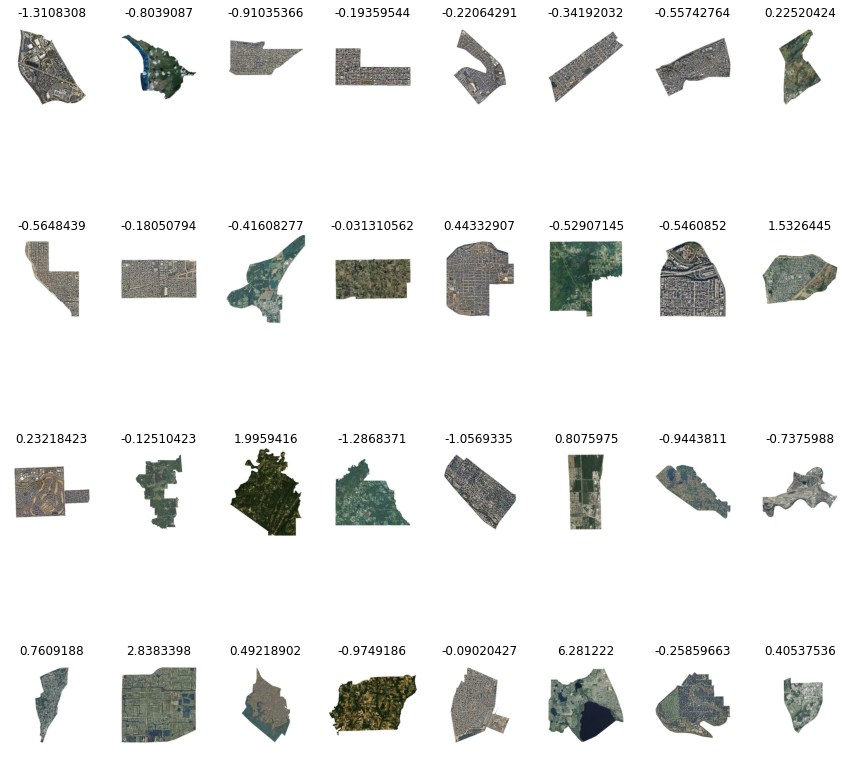

In [19]:
# Training data set visualization

for image, label in train_data.take(1):
    print("Image Batch Shape: ", image.numpy().shape)
    print("Labels: ", label.numpy())
    plt.figure(figsize=(15, 15))
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image[i].numpy().astype(np.uint8))
        plt.title(label[i].numpy())
        plt.axis("off")

## Model

This project's model is based on the one deployed by Robinson et. al. in [<a href=#1>1</a>]. They use a modified version of the VGG-A convolutional neural network, a well-known network architecture for image recognition, for the population estimation task. Their model features five blocks, each with convolutional layer(s) followed by a maxpooling layer. Finally, there are two fully connected layers feeding into a softmax operation. They use the softmax operation on network output because they are performing a classification task. Because this model performs regression, it feeds the last fully connected layer into a single numerical output.

<img src="VGG-A.png">

In [20]:
from tensorflow.keras import layers

img_height = 500
img_width = 500

In [21]:
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

In [22]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae','mse'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 500, 500, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 500, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 256)     295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 256)     5

### Training

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [25]:
EPOCHS = 20

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=early_stop
)

Epoch 1/20
792/792 [==============================] - 7999s 10s/step - loss: 1.1437 - mae: 0.7347 - mse: 1.1437 - val_loss: 1.0062 - val_mae: 0.7277 - val_mse: 1.0062
Epoch 2/20
792/792 [==============================] - 848s 1s/step - loss: 0.9961 - mae: 0.7205 - mse: 0.9961 - val_loss: 1.0062 - val_mae: 0.7278 - val_mse: 1.0062
Epoch 3/20
792/792 [==============================] - 848s 1s/step - loss: 0.9961 - mae: 0.7205 - mse: 0.9961 - val_loss: 1.0062 - val_mae: 0.7279 - val_mse: 1.0062
Epoch 4/20
792/792 [==============================] - 852s 1s/step - loss: 0.9961 - mae: 0.7205 - mse: 0.9961 - val_loss: 1.0062 - val_mae: 0.7278 - val_mse: 1.0062


#### Save Model

In [26]:
# Save the entire model as a SavedModel.
!cd drive/'My Drive'/population-estimation/saved_model
model.save('vgga-1')

/bin/bash: line 0: cd: drive/My Drive/population-estimation/saved_model: No such file or directory
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgga-1/assets


### Visualize Training Performance

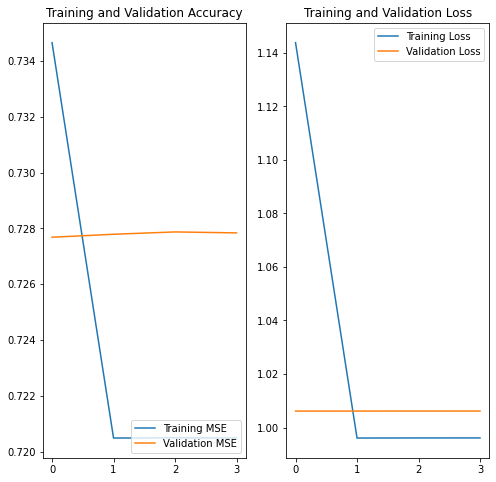

In [27]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MSE')
plt.plot(epochs_range, val_acc, label='Validation MSE')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Due to the large training set, the model reaches convergence after only a few epochs.

## Evaluation

In [28]:
'''
# Load saved model
model = tf.keras.models.load_model('drive/My Drive/population-estimation/saved_model/my_model')

# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
'''

"\n# Load saved model\nmodel = tf.keras.models.load_model('drive/My Drive/population-estimation/saved_model/my_model')\n\n# Evaluate the restored model\nloss, acc = new_model.evaluate(test_images, test_labels, verbose=2)\nprint('Restored model, accuracy: {:5.2f}%'.format(100 * acc))\n"

In [29]:
test_predictions = model.predict(test_data).flatten()

In [30]:
from sklearn import metrics

test_mae = metrics.mean_absolute_error(test_labels, test_predictions)
test_mse = metrics.mean_squared_error(test_labels, test_predictions)
test_r2 = metrics.r2_score(test_labels, test_predictions)

print("Test Set Mean Average Error: ",test_mae)
print("Test Set Mean Squared Error: ",test_mse)
print("R^2: ",test_r2)

Test Set Mean Average Error:  0.7342299943341339
Test Set Mean Squared Error:  1.0207736327693837
R^2:  -3.430785411362436e-05


Model performance fails to meet expectations. The model does show adequate generalization, with similar mean average error (mae) and mean squared error (mse) for training, validation, and testing splits. However, other quantitative measures of model performance are not strong. Test set evaluation shows an average error of 0.73 standard deviations. More telling is the R^2 value, which is effectively zero. This suggests that the model shows no meaningful information gain above memorizing the mean population. In fact, the plot of predictions vs. true populations below confirms that this is a largely accurate descriptor. I believe this lack of learning can be attributed to the scale variation in the data set, as discussed further in the Limitations section.

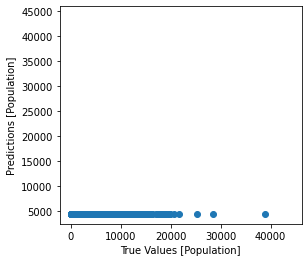

In [31]:
real_test_predictions = scaler.inverse_transform(test_predictions)
real_test_labels = scaler.inverse_transform(test_labels)

a = plt.axes(aspect='equal')
plt.scatter(real_test_labels, real_test_predictions)
plt.xlabel('True Values [Population]')
plt.ylabel('Predictions [Population]')
_ = plt.plot(44000,44000)

## Limitations / Improvements

One notable limitation to model performance is the scale variation of training regions. Census tracts can range in size from a city block (a few acres) to regions encompassing many square miles (upwards of thousands of acres). Because all images used as data had the same pixel dimensions (500x500), the model would have to infer region size from context within images. Despite the demonstrated success of the VGG-A model at feature recognition, I believe that the extreme range in tract sizes severely hampered performance. There are two potential solutions to this issue. The first involves working solely with data of fixed scale, as was done in prior work. The second would be to include a tract's land area as a separate numerical input to the model. Unfortunately, systematically obtaining this information for all tracts is not straightforward.

## References

[<a id=1>1</a>] Robinson, C., Hohman, F., & Dilkina, B. (2017, November). <a href="https://deeppop.github.io/resources/robinson2017-deeppop.pdf">A deep learning approach for population estimation from satellite imagery.</a> In Proceedings of the 1st ACM SIGSPATIAL Workshop on Geospatial Humanities (pp. 47-54).

[<a id=2>2</a>] Jacobs, N., Kraft, A., Rafique, M. U., & Sharma, R. D. (2018, November). <a href="https://arxiv.org/pdf/1810.09528.pdf">A weakly supervised approach for estimating spatial density functions from high-resolution satellite imagery.</a> In Proceedings of the 26th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 33-42).

[<a id=3>3</a>] Doupe, P., Bruzelius, E., Faghmous, J., & Ruchman, S. G. (2016, November). Equitable development through deep learning: The case of sub-national population density estimation. In Proceedings of the 7th Annual Symposium on Computing for Development (pp. 1-10).